# BSM
## Assumptions:
- Price of underlying asset follows a lognormal dist; return ~ normal
- $r_f^c$ is known and constant
- volatility $\sigma$ of underlying asset is known and constant
- Frictionless market
- No cash flow* (dividend)
- European options

## Formula
### European Call

$$c_0= S_0e^{-qT}*N(d1)- Xe^{-R_f^cxT} * N(d2)$$

$$d1 = \frac{ln(S_0/X) + (r-q+\sigma^2/2)T} {\sigma \sqrt{T}}$$

$$d2 = d1 - \sigma \sqrt{T}$$

### European Put

$$p_0= Xe^{-R_f^cxT}*N(-d2) - S_0e^{-qT}*N(-d1)$$

## Notes
- Call: `S0xN(d1)`: buy #delta stock & `-X` term: borrow money
- Put: `X` term: buy in a bond & `-S0xN(-d1)`: Short Stock
- Roughly: N(D1) = Prob. ITM before T
- N(D2) = Prlb(S_T > X) = Prob. Exercise at T

rfd quotes

My personal setup with options is to do non-directional short term trades to benefit of the rising implied volatility or simply sell expensive premium without betting on a single market direction. 

To make the best of options, one should implement complex strategies, which improves risk reward ratio. Butterflies, Iron Butterflies, double calendar, hedged sttaddle or strangle amd put/call ratio are better vehicles for the short term, which can greatly benefit from the increasing volatility of a nervous market without making bets on a single direction. 

If the goal is simplicity, I prefer to sell puts (get paid to buy the stock at the price you want) and once assigned, sell calls (to increase income and sell for a guaranteed profit). Once in cash again, rinse and repeat. If the market tanks when holding the stock, sell calls further out and have the temperament for market gyrations - it's temporary. 

This works very well with Canadian bank stocks or companies like Costco. Sell a put to buy with a 10% discount from current price. When it tanks enough and you are assigned, sell a call to have a 5% or 10% profit in a month or 2 out. Keep receiving the dividends and call premium meanwhile, until it's sold for your profit price. Repeat again, sell puts (collecting premium) until the price drops again, and so forth. This works forever on quality companies - main Canadian banks and Costco are just some examples. Also works on BCE and AT&T. Again, simple income strategy with fairly low risk. 

https://forums.redflagdeals.com/day-trading-option-2259692/
I personally find swing trading with options (larger timeframe) a lot easier than day trading. Technical analysis and multiple indicators help to validate trend / support / resistance, where you can place directional or non-directional trades. 


In [1]:
def newton(f, Df, x0, epsilon, max_iter):
    '''Approximate solution of f(x)=0 by Newton's method.
    https://www.math.ubc.ca/~pwalls/math-python/roots-optimization/newton/
    
    Parameters
    ----------
    f : function
        Function for which we are searching for a solution f(x)=0.
    Df : function
        Derivative of f(x).
    x0 : number
        Initial guess for a solution f(x)=0.
    epsilon : number
        Stopping criteria is abs(f(x)) < epsilon.
    max_iter : integer
        Maximum number of iterations of Newton's method.

    Returns
    -------
    xn : number
        Implement Newton's method: compute the linear approximation
        of f(x) at xn and find x intercept by the formula
            x = xn - f(xn)/Df(xn)
        Continue until abs(f(xn)) < epsilon and return xn.
        If Df(xn) == 0, return None. If the number of iterations
        exceeds max_iter, then return None.

    Examples
    --------
    >>> f = lambda x: x**2 - x - 1
    >>> Df = lambda x: 2*x - 1
    >>> newton(f,Df,1,1e-8,10)
    Found solution after 5 iterations.
    1.618033988749989
    '''
    xn = x0
    for n in range(0,max_iter):
        fxn = f(xn)
        if abs(fxn) < epsilon:
            print('Found solution after',n,'iterations.')
            return xn
        Dfxn = Df(xn)
        if Dfxn == 0:
            print('Zero derivative. No solution found.')
            return None
        xn = xn - fxn/Dfxn
    print('Exceeded maximum iterations. No solution found.')
    return None

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import log, sqrt, exp
from scipy import stats
from functools import partial

class Bsm(object):
    def __init__(self, s0, k, t, r, sigma=0.5, q=0):
        self.s0 = s0  # current stock price
        self.k = k  # strike price
        self.t = t  # time to expiration in years
        self.r = r  # continuous risk free rate
        self.q = q  # dividend rate
        self.sigma = sigma  # sd
        
    def d1(self, sigma_est=None):
        sigma = sigma_est or self.sigma
        return (log(self.s0/self.k) + (self.r - self.q + 0.5*sigma**2)*self.t)\
                / (sigma * sqrt(self.t))
    
    def d2(self, sigma_est=None):
        sigma = sigma_est or self.sigma
        return self.d1(sigma_est) - (sigma * sqrt(self.t))
    
    def call_value(self, sigma_est=None):
        return self.s0 * stats.norm.cdf(self.d1(sigma_est),0.,1.) - \
               self.k * exp(-self.r*self.t) * stats.norm.cdf(self.d2(sigma_est),0.,1.)
    
    def put_value(self, sigma_est=None):
        return self.k * exp(-self.r*self.t) * stats.norm.cdf(-self.d2(sigma_est),0.,1.) - \
               self.s0 * stats.norm.cdf(-self.d1(sigma_est),0.,1.)
    
    def vega(self, sigma_est=None):
        return self.s0 * stats.norm.pdf(self.d1(sigma_est),0.,1.) * sqrt(self.t)
    
    def call_iv_newton(self, c0, sigma_est=1., n=100):
        self.sigma_est = sigma_est
        f = lambda x: self.call_value(x) - c0
        df = lambda x: self.vega(x)
        return newton(f, df, sigma_est, 0.001, 100)

    def call_iv_dichotomy(self, c0):
        c_est = 0
        high = 3
        low = 0
        sigma = (high + low) / 2
        
        while abs(c0 - c_est) > 1e-8:
            c_est = self.call_value(sigma)
            # print(f'c_est = {c_est}, sigma = {sigma}')
            if c0 - c_est > 0:
                low = sigma
                sigma = (sigma + high) / 2
            else:
                high = sigma
                sigma = (low + sigma) / 2
        return sigma
    
    def __repr__(self):
        return f'Base(s0={self.s0}, k={self.k}, t={self.t}, r={self.r})'

In [3]:
bsm1 = Bsm(s0=100, k=100, t=1.0, r=0.05, q=0, sigma=0.3)
n_d1 = stats.norm.cdf(bsm1.d1(), 0., 1.)
bsm1.call_value()

14.231254785985819

In [4]:
bsm2 = Bsm(s0=100, k=100, t=1.0, r=0.05, q=0,)
#bsm2.call_iv_newton(c0=14.2313, n=10)
bsm2.call_iv_dichotomy(c0=14.2313)

0.300001191732008

In [39]:
def iv(df, current_date, strike_date, s0, rf):
    k = df['Strike']
    call = (df['Bid'] + df['Ask']) / 2
    t = (pd.Timestamp(strike_date) - pd.Timestamp(current_date)).days / 365
    
    sigma_init = 1
    sigma_newton = []
    sigma_dichotomy = []

    for i in range(df.shape[0]):
        model = Bsm(s0, k[i], t, rf)
        try:
            sigma_newton.append(model.call_iv_newton(c0=call[i], sigma_est=sigma_init))
            #sigma_dichotomy.append(model.call_iv_dichotomy(c0=call[i]))
        except ZeroDivisionError as zde:
            print(f'{zde!r}: {model!r}')
            sigma_dichotomy.append(None)
    return sigma_newton, sigma_dichotomy


In [40]:
s0 = 1290.69
rf = 0.0248 # libor

pd_read_excel = partial(pd.read_excel, 'OEX1290.69.xlsx', skiprows=3)
df_05 = pd_read_excel(sheet_name='20190517')
df_06 = pd_read_excel(sheet_name='20190621')
df_07 = pd_read_excel(sheet_name='20190719')
df_09 = pd_read_excel(sheet_name='20190930')


iv_05 = iv(df_05, '20190422', '20190517', s0, rf)
iv_06 = iv(df_06, '20190422', '20190621', s0, rf)
iv_07 = iv(df_07, '20190422', '20190719', s0, rf)
iv_09 = iv(df_09, '20190422', '20190930', s0, rf)

Found solution after 6 iterations.
Zero derivative. No solution found.
Found solution after 5 iterations.
Zero derivative. No solution found.
Found solution after 4 iterations.
Zero derivative. No solution found.
Found solution after 3 iterations.
Zero derivative. No solution found.
Found solution after 2 iterations.
Zero derivative. No solution found.
Found solution after 3 iterations.
Zero derivative. No solution found.
Found solution after 4 iterations.
Zero derivative. No solution found.
Found solution after 4 iterations.
Found solution after 4 iterations.
Zero derivative. No solution found.
Found solution after 4 iterations.
Zero derivative. No solution found.
Found solution after 4 iterations.
Zero derivative. No solution found.
Found solution after 5 iterations.
Zero derivative. No solution found.
Found solution after 5 iterations.
Found solution after 5 iterations.
Zero derivative. No solution found.
Found solution after 5 iterations.
Zero derivative. No solution found.
Found s

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


Found solution after 5 iterations.
Found solution after 5 iterations.
Found solution after 5 iterations.
Found solution after 6 iterations.
Found solution after 6 iterations.
Found solution after 6 iterations.
Found solution after 6 iterations.
Found solution after 6 iterations.
Found solution after 6 iterations.
Found solution after 6 iterations.
Found solution after 6 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 6 iterations.
Found solution after 6 iterations.
Found solution after 6 iterations.
Found solution after 6 iterations.
Found solution after 6 iterations.
Zero derivative. No solution found.
Found solution afte

Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Found solution after 7 iterations.
Zero derivative. No solution found.
Zero derivative. No solution found.
Zero derivative. No solution found.
Zero derivative. No solution found.
Zero derivative. No solution found.
Zero derivative. No solution found.
Zero derivative. No solution found.
Zero derivative. No solution found.
Zero derivative. No solution found.
Zero derivative. No solution found.
Zero derivative. No solution found.
Zero derivative. No solution found.
Zero der

No handles with labels found to put in legend.


116 116
134 134
112 112
90 90


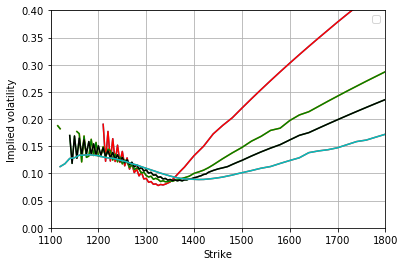

In [41]:
dfs = [df_05, df_06, df_07, df_09]
ivs = [iv_05, iv_06, iv_07, iv_09]
color = (c for c in ['r', 'g', 'k', 'c'])

for result in zip(dfs, ivs):
    k = result[0]['Strike']
    iv_newton = result[1][0]
    print(len(k), len(iv_newton))
    plt.plot(k, iv_newton, lw=1.5)
    plt.plot(k, iv_newton, next(color))

plt.grid(True)
plt.xlabel('Strike')
plt.ylabel('Implied volatility')
plt.legend()
plt.xlim(1100, 1800)
plt.ylim(0, .4)
plt.show()

# Option Greeks
BSM 5 inputs:
1. Underlying asset price -> $\frac{\Delta C}{\Delta S}$ Delta ---> Gamma
1. Volatility             -> $\frac{\Delta C}{\Delta \sigma}$ Vega
1. risk-free rate         -> $\frac{\Delta C}{\Delta r_f}$ Rho (rate)
1. time to expiration     -> $\frac{\Delta C}{\Delta t}$ Theta
1. strike price           -> $\frac{\Delta C}{\Delta X}$ X/K


- `S+` --> `C+` (0<=Delta<=1)
- `S-` --> `P+` (-1<=Delta<=0)
- $\sigma$+  -->  `C+` & `P+` (Vega>0)
- $r_f$+   -->  `C+` (Rho>0) (C=P+S-K/(1+__r__)^T)
- $r_f$-   -->  `P+` (Rho<0)
- Theta < 0; Time decay*
- `X-`  --> `C+`
- `X+`  --> `P+`
- Long: `Gamma>0`; Short: `Gamma<0`
- `Gamma` max at ATM, approaches 0 when deep ITM or OTM

## Delta
- Sensitivity of the option price to a change in the price of the underlying asset
- One option = delta stock
- $delta_{call} = \Delta C / \Delta S = N(d1)$
- $delta_{put} = \Delta P / \Delta S = delta_{call} - 1 = N(d1) - 1$

- 0 when deep OTM
  - option price not censitive to $\delta S$
- $\pm1$ when deep ITM
  - very sensitive. 1-1 ratio on stock price
- $\pm0.5$ around `X`
- When t->T
  - ITM delta_c --> 1
  - OTM delta_c --> 0
  
### delta_p = delta_c - 1
- Forward on S = Call on S - Put on S
- FP = C - P --> $dC/dS - dP/dS = d{FP}/dS$
    - FP and S relation: 1:1 
    - delta_p = delta_c - 1

### N(d1) = delta_c
- $\frac{dBSM}{dS} = N(d1) + 0 = delta_c$

### Dynamic hedging
- TL;DR: adjusting # of call options to make delta-neutral portfolio
- delta-neutral protfolio. value of the portfolio remains unchanged
  - `+ S - h*C`, h=1/delta
  - when S increased by n dollar, call decrease by $delta \times n$; delta calls decrease n dollar
- hedge ratio depends on which hedges which
  - Long Stock &
  - short call / long put
- portfolio value unchanged: 
  - need: $\Delta_{portfolio} / \Delta S = 0$
  - $nS \times \Delta S - nC \times \Delta C = 0$
  - $\frac{\Delta C}{\Delta S} = \frac{nS}{nC} = delta_{call}$
- Dynamic
  - as t -> T, delta is changing (to OTM 0 or ITM 1)
  - $nS$ remains unchanged, need to change $nC$
- Maximum Cost
  - change of delta is fast (Gamma max)
  - max at ATM
  - rebalance portfolio more frequently -> higher transaction cost

## Gamma
- Sensitivity of the option delta to a change in the price of the underlying asset
- $gamma = \Delta delta / \Delta S$
- Call and put options on the same stock with same T and X have equal gammas


## Vega
- sensitivity of the option value to a change in the volatility of the underlying asset

## Theta
- sensitivity of the option value to a change in the calendar time
- Time decay

## Rho
- sensitivity of the option value to a change in the $r_f$
- leverage effect. rho>0 for call
- small impact compared to vega

## Volatility
1. Historical Volatility
    - using historical data to calculate the variance and s.d. of the continuously compounded returns
    - $S_{R_i^c}^2 = \frac{\Sigma_{i=1}^N(R_i^c-\bar{R_i^c})^2}{N-1}$
    - $\sigma = \sqrt{S_{R_i^c}^2}$
1. Implied Volatility
  - Calculate $\sigma$ backwards
  - IV=20%, Historical=10% -> Option Overvalued

# Strategies
## Synthetic
- Synthetic long/short asset
  - C - P = +S = Forward
  - P - C = -S
- Synthetic call/put
  - C = S + P
  - P = -S + C
- Synthetic Stock
  - Equity = rf + forward/futures
  - Synthetic Equity = risk-free asset + stock futures
- Synthetic Cash
  - rf = Stock - Forward
  - Synthetic risk-free asset = Stock - stock futures
      - S0=10, 1yr FP, rf=10% no div
      - Long stock - forward; 
      - $FP=S_0*(1+r_f)^T$
      - if S1=12: stock+=2, (-forward)-=1 => portfolio+=1
      - if S1=8: stock-=2, (-forward)+=3 => portfolio+=1

## Fiduciary call: C + bond
- C(X,T)
- Pure-discount bond pays X in T years
- Payoff:
  - $S_T \le X$: $X$
  - $S_T > X$: $S_T$

## Covered call: $S - C$
- Neutral
- Call covered by a stock
- 股价温和上涨， 达不到X; CG + call premium
- Same as: Short Put
- profit: $(S_T-S_0) - max\{0, (S_T-X)\} + C$
    - Cost / break even: $S_T = S_0 - C$
    - Max loss at $S_T=0$
        - All the cost: $-(S_0 - C)$
    - Max profit at $S_T \ge X$
        - Constant: $X - (S_0 - C)$ 

## Protective put: $S + P_{atm}$
- Bullish
- Married Put
- Same as: long call
- Pros: 
    - unlimited profit
- Cons:
    - Pay put premium
    - Lower total return
    - Put will expire
- Deductible: $S_0 - X$
    - If lower the cost, higher deductible
    - i.e., more OTM
- profit: $(S_T-S_0) + max\{0,(X-S_T)\} - P$
    - Cost: $P + S_0$
    - Max loss at $S_T<X$
        - $ X - (P + S_0)$: Strike price - cost
    - Gain at $S_T > P_0 + S_0$    

## Bull Call Spread
- (bullish) benefit from a stock's limited increase in price.
- Long 1 call & 
- short 1 call, the same expiry, __higher__ X
- Trade-off:
    - Reduce promium
    - Limit upside profit potential
- Max loss: 
    - Net_premium_spent x 100
- Max upside profit potential:
    - (call spread width - premium spent) x 100
- Breakeven:
    - Lower X + net premium spent

## Bear Put Spread
- bearish. moderate decline
- Long 1 put & Short 1 put at lower strike

## Collar
- protect against large losses & limits large gains
- Currently long 100 shares with a gain
- Sell 1 OTM call & 
- buy 1 OTM put, same expiry
- Max Loss: Limited
    - Net debit: Put X - Stock purchase price - net premium paid
    - Net credit: Put X - Stock purchase price + net premium collected
- Max Profit: Limited
    - Net debit: Call X - Stock purchase price - net premium paid
    - Net credit: Call X - Stock purchase price + net premium collected
- Breakeven:
    - Net debit: Stock purchase price + net premium paid
    - Net credit: Stock purchase price - net premium collected

## Straddle
- Profit from a very strong move in either direction
- Move from low volatility to high volatility
- `\/`
- Long 1 call ATM &
- Long 1 put ATM on same S, same T and same X
    - X is very close to ATM
- Max Loss: Limited
    - at X: (Call + Put premium) x 100
- Max Profit: Unlimited
- Breakeven:
    - Up: Call strike + call premium + put premium
    - Down: Put strike - call premium - put premium

## Strangle
- Long 1 OTM Call & 
- Long 1 OTM Put, Put X < Call X
- Net debit
- `\_/`
- Breakeven:
    - Up: Call strike + put premium + call premium
    - Down: Put strike - put premium - call premium
- Max loss: limited
    - put premium + call premium + commission
    - between put X and call X

## Butterfly
- Neutral
- net debit
- a bull spread + a bear spread
    - Long 1 ITM Call
    - Short 2 ATM Call
    - Long 1 OTM Call
- `_/\_`
- Net premium = C_ITM - 2xC_ATM + C_OTM
- Breakeven:
    - Lower: Long Call Lower X + Net premium
    - Upper: Long Call Higher X - Net premium
- Max loss: limited
    - Net premium + commission
    - when underlying <= Long Call Lower X OR underlying >= Long Call Upper X
- Max profit: limited
    - Short Call X - Long Call Lower X - Net premium - commission
    - when underlying = Short Call X
 

## Condor
- Limited profit: Low IV
- Long outside X, Short middle X
    - Long 1 ITM Call (Lower X)
    - Short 1 ITM Call
    - Short 1 OTM Call
    - Long 1 OTM Call (Higher X)
- Same T, 
- Long Condor: `_/T\_`. Cut off  butterfly

- Breakeven:
    - Lower: Long Call Lower X + Net premium
    - Upper: Long Call Higher X - Net premium
- Max loss: limited
    - Net premium + commission
    - when underlying <= Long Call Lower X OR underlying >= Long Call Upper X
- Max profit: limited
    - Short Call X - Long Call Lower X - Net premium - commission
    - when underlying between 2 short calls

## Iron Condor:
- Call Bull spread + Put Bear spread
    - Long 1 ITM Call
    - Short 1 ITM Call
    - Short 1 ITM Put
    - Long 1 ITM Put

- Breakeven:
    - Lower: Short Call X + Net premium
    - Upper: Short Put X - Net premium
- Max profit: limited
    - Net premium + commission
    - when underlying between 2 short calls
- Max loss: limited
    - Long Call X - Short Call X - Net premium - commission
    - when underlying <= Long Call X OR underlying >= Long Put X

## Iron Butterfly
- When IV is Ext. high
- Long 1 OTM Put
- Short 1 ATM Put
- Short 1 ATM Call
- Long 1 OTM Call